In [1]:
from printrun.printcore import printcore
from printrun import gcoder
import time
import pyvisa
from IPython.display import display, clear_output
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

## Connect to Devices

##### Scope

In [16]:
rm = pyvisa.ResourceManager()
rm.list_resources()
scope = rm.open_resource('USB0::0x1AB1::0x044D::DHO8A254404063::INSTR')
print(f'Scope: {scope.query('*IDN?')}')

Scope: RIGOL TECHNOLOGIES,DHO804,DHO8A254404063,00.01.01



##### 3D Printer

In [17]:
# Connect to printer
p = printcore("COM3", 115200)

## Set Up

##### Scope

In [4]:
scope.write(":TIM:SCAL 0.00001")  # Set timebase to 10 us/div
scope.write(":CHAN1:OFFS 0")
scope.write(":CHAN1:SCAL 0.5")    # Set CH1 voltage scale to 200mV/div
scope.write(":ACQ:TYPE AVER")
scope.write(":ACQ:AVER 4")
# scope.write(":TRIG:LEV 0.5")    # Set trigger level to 0.5V

13

##### 3D Printer

In [26]:
p.send("G91")

In [18]:
p.send("G28")

In [28]:
p.send("G1 Z-20 F12000")

In [19]:
p.send("G1 X150 Y100 F12000")

In [19]:
p.send("G1 X150 Y100 Z380 F12000")

## Measurement Function

In [29]:
def measure_scope_vpp():
    measurements = np.array([float(scope.query(":MEAS:VPP? CHAN1")) for _ in range(5)])
    meas_avg = np.average(sorted(measurements)[2:])
    return meas_avg

## 3D Printer Movement and Data Acquisition

In [30]:
# Find peak (center)
p.send("G1 X-15 Y-15 F12000")
(x_max, y_max) = (0,0)
max_measure = 0
for i in tqdm(range(30)):
    for j in tqdm(range(30)):
        measurement = measure_scope_vpp()
        if measurement > max_measure:
            max_measure = measurement
            x_max = j
            y_max = i
        p.send("G1 X1 F12000")
    p.send("G1 X-30 Y1 F12000")
    time.sleep(0.5)
p.send("G1 Y-30 F12000")
time.sleep(0.5)
p.send(f"G1 X{x_max} Y{y_max} F12000")

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [35]:
p.send("G1 Z-10 F12000")

In [31]:
z_planes = 1
y_points = 50
x_points = 50
x_range = 50 # mm
y_range = 50 # mm
x_movement = x_range / x_points 
y_movement = y_range / y_points
measurements = np.zeros((z_planes, y_points, x_points))
p.send(f'G1 X-{x_range/2} Y-{y_range/2} F12000')
time.sleep(2)
for i in tqdm(range(z_planes)): # Z
    for j in tqdm(range(y_points)): # Y 
        for k in tqdm(range(x_points)): # X
            # Measure here
            measurements[i,j,k] = measure_scope_vpp()
            p.send(f"G1 X{x_movement} F3000")
        # Measure last x point 
        p.send(f"G1 X-{x_range} Y{y_movement} F3000")
        time.sleep(1)
    p.send(f"G1 Y-{y_range} Z10 F3000")
    time.sleep(5)
p.send(f'G1 X{x_range/2} Y{y_range/2} Z{z_planes * 10} F12000')
print(measurements)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[[[0.09748767 0.07186667 0.10513233 ... 0.03399967 0.04644467 0.04715567]
  [0.18175667 0.24109    0.26913333 ... 0.03133367 0.045489   0.05355567]
  [0.14037567 0.21671333 0.23617667 ... 0.04173333 0.06013333 0.070667  ]
  ...
  [0.22006667 0.18242233 0.26668667 ... 0.01604433 0.01535533 0.02948867]
  [0.22033667 0.166509   0.20611    ... 0.0274     0.034267   0.03206633]
  [0.21062333 0.08886667 0.13939867 ... 0.04984467 0.05351133 0.04035533]]]


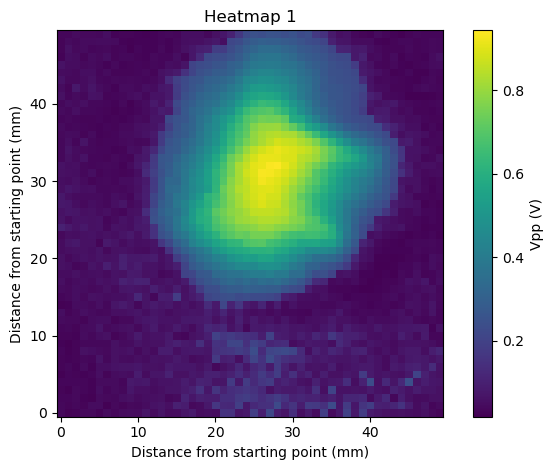

In [ ]:
# Plot and save
img1 = plt.imshow(measurements[0], cmap="viridis", interpolation="nearest", origin="lower")
plt.title("Heatmap 1")
plt.xlabel("Distance from starting point (mm)")
plt.ylabel("Distance from starting point (mm)")

# Add colorbars
plt.colorbar(img1, label="Vpp (V)")

# Show the plots
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

# Save data
np.savetxt("3_13_25_no_object_0.csv", measurements[0], delimiter=",", fmt="%.2f")  # fmt controls number formatting